In [0]:
import numpy as np
import random 
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

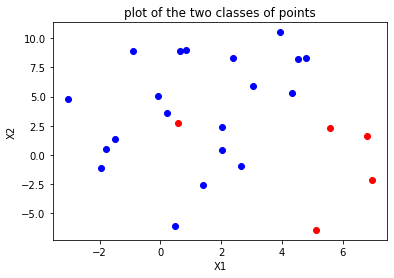

In [0]:
# first generate and plot the data 
# generate red and green dots from two Gaussian distribution
N1=5
N2=20
np.random.seed(20)
X01 = np.ones((N1,1))
X02 = np.ones((N2,1))
mu1=[4,1]
Sigma1=[[10,0], [0,10]]
mu2=[1,4]
Sigma2=[[10,0], [0,10]]
X1=np.random.multivariate_normal(mu1,Sigma1, size=N1)
y1=np.ones((N1,1))
y2=-np.ones((N2,1))
X2=np.random.multivariate_normal(mu2,Sigma2, size=N2)
Redx=np.hstack((X01,X1))
Bluex=np.hstack((X02,X2))
# combine two classes of dots
X=np.concatenate((X1,X2))
Xqp=np.concatenate((Redx, Bluex))
y=np.concatenate((y1,y2))
# plot these dots
plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')
plt.title("plot of the two classes of points")
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### Search for the best cost 

In [0]:
param_grid = {'C': (0.1)**np.arange(0,3)}
search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=5)
search.fit(X, y.ravel())
I=-math.log10(search.best_params_['C'])
param_grid2 = {'C': (0.1)**np.arange(I-0.9,I+1, step=0.2)}
search2 = GridSearchCV(SVC(kernel='linear'), param_grid2, cv=5)
search2.fit(X, y.ravel())
Cbest=search2.best_params_['C']

In [0]:
Cbest

7.943282347242815

## SVM from Quadratic Programming

Here we minimize $1/2 ||\beta||^2 + C(\sum_{i=1}^n \xi_i)$ \\
subject to $y_i(x^T\beta+\beta_0) \geq 1-\xi_i, i = 1, \dots, n$, and $\xi_i \geq 0, i=1, \dots, n $

We are trying to rewrite the problem in following format:
minimize $1/2 x^TGx + a^Tx$ w.r.t. $x$, \\
subject to $Cx\geq b$ \\

In [0]:
# !pip install quadprog
! CVXOPT_BUILD_GLPK=1 pip install cvxopt

In [0]:
# get the number of parameters in beta, including beta_0
nbeta=Xqp.shape[1]
# get total number of samples
nsample=Xqp.shape[0]
G=np.identity(nbeta+nsample)
G[0,0]=0
for i in range(nbeta, nbeta+nsample):
  G[i,i]=0

In [0]:
# create a
# a= np.concatenate((a1, a2))
# define cost C
Cost=Cbest
a1=np.zeros((nbeta))
a2=Cost*np.ones((nsample))
a= np.concatenate((a1, a2))

In [0]:
# create C=np.concatenate(Q, O)
Q11=y*Xqp
Q12=np.zeros((nsample,nsample))
Q1=np.hstack((Q11, Q12))
Q21=np.zeros((nsample,nbeta))
Q22=np.identity(nsample)
Q2=np.hstack((Q21, Q22))
Q=Q1+Q2
# O=Q2
C=np.concatenate((Q, Q2))

In [0]:
# create b
# b = np.concatenate((b1, b2))
b1=np.ones((nsample))
b2=np.zeros((nsample))
b=np.concatenate((b1, b2))

In [0]:
from cvxpy import *
# optimization variables
#x = Variable(5)
x=Variable(nsample+nbeta)

# build optimization problem
objective = Minimize( 0.5 * quad_form(x, G) + a.T * x)
constraints = [ C * x >= b ]
prob = Problem(objective, constraints)

# solve optimization problem
prob.solve()
print ("beta  =", x.value[0:nbeta])

beta  = [-2.1539871   0.5001975  -0.15123859]


In [0]:
# SVM
SVMsl=SVC(kernel='linear', C=Cbest)
SVMsl.fit(X, y.ravel())
print ("coef of SVM from scikit-learn is ", [SVMsl.intercept_,SVMsl.coef_[0][0], SVMsl.coef_[0][1]])

coef of SVM from scikit-learn is  [array([-2.15449887]), 0.50031129520832, -0.15120905831053122]


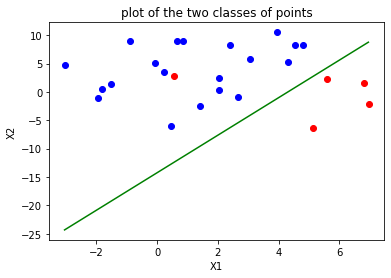

In [0]:
# result from SVM
beta0=SVMsl.intercept_[0]
beta1=SVMsl.coef_[0][0]
beta2=SVMsl.coef_[0][1]
linex=np.arange(np.amin(Xqp[:,1]),np.amax(Xqp[:,1]), step=0.2)
liney=-beta0/beta2-beta1/beta2*linex
#result from quadratic programming
#QPbeta0=QP[0]
#QPbeta1=QP[1]
#QPbeta2=QP[2]
#QPlinex=np.arange(min(Xqp[1]),max(Xqp[1]), step=0.2)
#QPliney=-QPbeta0/QPbeta2-QPbeta1/QPbeta2*QPlinex
# plot
plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')
plt.plot(linex, liney, '-g')
#plt.plot(QPlinex, QPliney, '-r')
plt.title("plot of the two classes of points")
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## Different weight on error

Assume classify 1 to (-1) has cost $C_1$, while classify (-1) to 1 has cost $C_2$, thus the original $C\sum_{i=1}^n \xi_i$ is now be $C_1\sum_{i=1}^n \frac{y_i^2+y_i}{2}\xi_i + C_2 \sum_{i=1}^n\frac{y_i^2-y_i}{2}\xi_i$. Everything else does not change, thus we only need to updated $a$ compared to the original SVM. 

In [0]:
# get the number of parameters in beta, including beta_0
nbeta=Xqp.shape[1]
# get total number of samples
nsample=Xqp.shape[0]
G=np.identity(nbeta+nsample)
G[0,0]=0
for i in range(nbeta, nbeta+nsample):
  G[i,i]=0

In [0]:
# create a
# a= np.concatenate((a1, a2))
# define cost C
C1=Cbest*1.5
C2=Cbest*0.5
a1=np.zeros((nbeta))
a2=C1*(y**2+y)*0.5+C2*(y**2-y)*0.5
a= np.concatenate((a1, a2.ravel()))

In [0]:
# create C=np.concatenate(Q, O)
Q11=y*Xqp
Q12=np.zeros((nsample,nsample))
Q1=np.hstack((Q11, Q12))
Q21=np.zeros((nsample,nbeta))
Q22=np.identity(nsample)
Q2=np.hstack((Q21, Q22))
Q=Q1+Q2
# O=Q2
C=np.concatenate((Q, Q2))

In [0]:
# create b
# b = np.concatenate((b1, b2))
b1=np.ones((nsample))
b2=np.zeros((nsample))
b=np.concatenate((b1, b2))

In [0]:
from cvxpy import *
import numpy as np

# optimization variables
#x = Variable(5)
x=Variable(nsample+nbeta)

# build optimization problem
objective = Minimize( 0.5 * quad_form(x, G) + a.T * x )
constraints = [ C * x >= b ]
prob = Problem(objective, constraints)

# solve optimization problem
prob.solve()
print ("beta  =", x.value[0:nbeta])

beta  = [-1.87198913  0.4485991  -0.10886486]


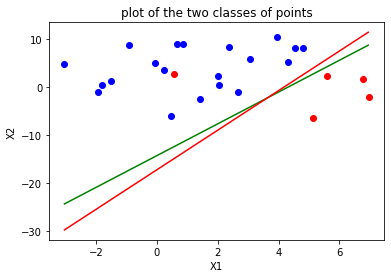

In [0]:
# result from SVM
beta0=SVMsl.intercept_[0]
beta1=SVMsl.coef_[0][0]
beta2=SVMsl.coef_[0][1]
linex=np.arange(np.amin(Xqp[:,1]),np.amax(Xqp[:,1]), step=0.2)
liney=-beta0/beta2-beta1/beta2*linex
#result from quadratic programming
QP=x.value[0:nbeta]
QPbeta0=QP[0]
QPbeta1=QP[1]
QPbeta2=QP[2]
QPlinex=linex
QPliney=-QPbeta0/QPbeta2-QPbeta1/QPbeta2*QPlinex
# plot
plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')
plt.plot(linex, liney, '-g')
plt.plot(QPlinex, QPliney, '-r')
plt.title("plot of the two classes of points")
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### Consider Other type of error function
If we want to give more weight on bigger $\xi$ we can use $\xi^2$ instead of $\xi$ in the objective function. thus the original $C\sum_{i=1}^n \xi_i$ is now be $C_1\sum_{i=1}^n \frac{y_i^2+y_i}{2}\xi_i^2 + C_2 \sum_{i=1}^n\frac{y_i^2-y_i}{2}\xi_i^2$. Everything else does not change, thus we only need to updated $G$, and get rid of $a$ compared to the original SVM.

In [0]:
# get the number of parameters in beta, including beta_0
nbeta=Xqp.shape[1]
# get total number of samples
nsample=Xqp.shape[0]
G=np.identity(nbeta+nsample)
G[0,0]=0
C1=Cbest*1.5
C2=Cbest*0.5
for i in range(nsample):
  yi=y[i].item()
  G[i+nbeta, i+nbeta]=C1*(yi**2+yi)+C2*(yi**2-yi)

# create a
# a= np.concatenate((a1, a2))
# define cost C
C1=Cbest*1.5
C2=Cbest*0.5
a1=np.zeros((nbeta))
a2=C1*(y**2+y)*0.5+C2*(y**2-y)*0.5
a= np.concatenate((a1, a2.ravel()))


# create C=np.concatenate(Q, O)
Q11=y*Xqp
Q12=np.zeros((nsample,nsample))
Q1=np.hstack((Q11, Q12))
Q21=np.zeros((nsample,nbeta))
Q22=np.identity(nsample)
Q2=np.hstack((Q21, Q22))
Q=Q1+Q2
# O=Q2
C=np.concatenate((Q, Q2))

# create b
# b = np.concatenate((b1, b2))
b1=np.ones((nsample))
b2=np.zeros((nsample))
b=np.concatenate((b1, b2))

In [0]:
from cvxpy import *
import numpy as np

# optimization variables
#x = Variable(5)
x=Variable(nsample+nbeta)

# build optimization problem
objective = Minimize( 0.5 * quad_form(x, G))
constraints = [ C * x >= b ]
prob = Problem(objective, constraints)

# solve optimization problem
prob.solve()
print ("beta  =", x.value[0:nbeta])

beta  = [-0.58330001  0.20157955 -0.07849172]


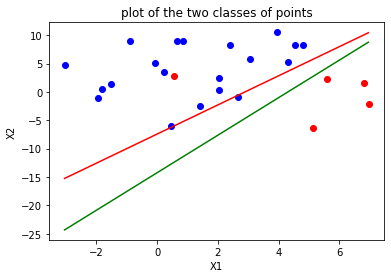

In [0]:
# result from SVM
beta0=SVMsl.intercept_[0]
beta1=SVMsl.coef_[0][0]
beta2=SVMsl.coef_[0][1]
linex=np.arange(np.amin(Xqp[:,1]),np.amax(Xqp[:,1]), step=0.2)
liney=-beta0/beta2-beta1/beta2*linex
#result from quadratic programming
QP=x.value[0:nbeta]
QPbeta0=QP[0]
QPbeta1=QP[1]
QPbeta2=QP[2]
QPlinex=linex
QPliney=-QPbeta0/QPbeta2-QPbeta1/QPbeta2*QPlinex
# plot
plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')
plt.plot(linex, liney, '-g')
plt.plot(QPlinex, QPliney, '-r')
plt.title("plot of the two classes of points")
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### Another loss function
consider another loss function, if missclassifying 1 to -1, the loss is $f(\xi)=0 for 0\leq\xi\leq1$, and $f(\xi)=C_1(\xi-1) for \xi>1$. If missclassifying -1 to 1, the loss is $f(\xi)=0 for 0\leq\xi\leq1$ and $f(\xi)=C_2(\xi-1) for \xi>1$

### Make prediction

In [0]:
## make prediction
Xqp=np.asmatrix(Xqp)
QP=np.asmatrix(QP)
ypred=-np.ones((nsample,1))
ypred[Xqp@QP.T>0]=1
# correct prediction
np.sum(y==ypred)/nsample

0.44

In [0]:
# SVM result
ypredsvm=SVMsl.predict(X)
# correct prediction
np.sum(y.ravel()==ypredsvm)/nsample

0.96

### Calcuate the Loss based on unequal loss

Calculate the loss if we assume unequal loss for misclassifying these two classes. Assume $Loss1$ for missclassifying $1$ to $(-1)$, and assume $Loss2$ for missclassifying $(-1)$ to $1$. 

In [0]:
Loss1=3
Loss2=1
# for svm
Losssvm=0
for i in range(nsample):
  yi=y[i].item()
  if yi-ypredsvm[i]==2:
    Losssvm=Losssvm+Loss1
  if yi-ypredsvm[i]==-2:
    Losssvm=Losssvm+Loss2
print("Loss from SVM", Losssvm)

# for quadratic programming
Lossqp=0
for i in range(nsample):
  yi=y[i].item()
  if yi-ypred[i]==2:
    Lossqp=Lossqp+Loss1
  if yi-ypred[i]==-2:
    Lossqp=Lossqp+Loss2
print("Loss from square xi loss", Lossqp)

Loss from SVM 3
Loss from square xi loss 18


## Grid search to find the best parameter giving the least loss


In [0]:
# first create the function to get loss
def getloss(X, y, Loss1, Loss2, beta0, beta1, beta2):
  # X is the covariate matrix, with dim of n*3
  # y is the label, +1 and -1
  # Loss1 is the loss for classifying 1 to -1
  # Loss2 is the loss for classifying -1 to 1
  # beta0, beta1, and beta2 are the coefficient for decision plane
  # decision function is y=beta0+beta1*x1+beta2*x2
  import numpy as np
  X=np.asmatrix(X)
  beta=np.array([beta0, beta1, beta2])
  beta=np.asmatrix(beta)
  ypred=-np.ones((X.shape[0],1))
  ypred[X@beta.T>0]=1
  Loss=0
  for i in range(X.shape[0]):
    yi=y[i].item()
    if yi-ypred[i]==2:
      Loss=Loss+Loss1
    if yi-ypred[i]==-2:
      Loss=Loss+Loss2
  return(Loss)

# testQP
# getloss(X=Xqp, y=y, Loss1=3, Loss2=1, beta0=0.3518948, beta1=0.15046421, beta2=-0.1306985)
# test SVM
# getloss(X=Xqp, y=y, Loss1=3, Loss2=1, beta0=-0.01818894, beta1=0.30520880471687156, beta2=-0.2588753707983081)

### Grid search for best parameter combination


In [0]:
betabest=np.array([0,0,0])
beta0v=np.arange(-10,10,step=1)
beta1v=np.arange(-10,10,step=1)
beta2v=np.arange(-10,10,step=1)
Loss1=3
Loss2=1
Lossmin=Xqp.shape[0]*Loss1
# round 1
for beta0 in beta0v:
  for beta1 in beta1v:
    for beta2 in beta2v:
      temploss=getloss(X=Xqp, y=y, Loss1=Loss1, Loss2=Loss2, beta0=beta0, beta1=beta1, beta2=beta2)
      if temploss<Lossmin:
        betabest=np.array([beta0,beta1,beta2])
        Lossmin=temploss
print("Round 1")
print("best parameter combination is ", betabest)
print("minimal loss is ", Lossmin)
# round 2
beta0v=np.arange(betabest[0]-1, betabest[0]+1, step=0.2)
beta1v=np.arange(betabest[1]-1, betabest[1]+1, step=0.2)
beta2v=np.arange(betabest[2]-1, betabest[2]+1, step=0.2)
for beta0 in beta0v:
  for beta1 in beta1v:
    for beta2 in beta2v:
      temploss=getloss(X=Xqp, y=y, Loss1=Loss1, Loss2=Loss2, beta0=beta0, beta1=beta1, beta2=beta2)
      if temploss<Lossmin:
        betabest=np.array([beta0,beta1,beta2])
        Lossmin=temploss
print("Round 2")
print("best parameter combination is ", betabest)
print("minimal loss is ", Lossmin)
# round 3
beta0v=np.arange(betabest[0]-0.2, betabest[0]+0.2, step=0.04)
beta1v=np.arange(betabest[1]-0.2, betabest[1]+0.2, step=0.04)
beta2v=np.arange(betabest[2]-0.2, betabest[2]+0.2, step=0.04)
for beta0 in beta0v:
  for beta1 in beta1v:
    for beta2 in beta2v:
      temploss=getloss(X=Xqp, y=y, Loss1=Loss1, Loss2=Loss2, beta0=beta0, beta1=beta1, beta2=beta2)
      if temploss<Lossmin:
        betabest=np.array([beta0,beta1,beta2])
        Lossmin=temploss
print("Round 3")
print("best parameter combination is ", betabest)
print("minimal loss is ", Lossmin)
# round 4
beta0v=np.arange(betabest[0]-0.04, betabest[0]+0.04, step=0.01)
beta1v=np.arange(betabest[1]-0.04, betabest[1]+0.04, step=0.01)
beta2v=np.arange(betabest[2]-0.04, betabest[2]+0.04, step=0.01)
for beta0 in beta0v:
  for beta1 in beta1v:
    for beta2 in beta2v:
      temploss=getloss(X=Xqp, y=y, Loss1=Loss1, Loss2=Loss2, beta0=beta0, beta1=beta1, beta2=beta2)
      if temploss<Lossmin:
        betabest=np.array([beta0,beta1,beta2])
        Lossmin=temploss

print("Final")
print("best parameter combination is ", betabest)
print("minimal loss is ", Lossmin)

Round 1
best parameter combination is  [-10   2   0]
minimal loss is  3
Round 2
best parameter combination is  [-10   2   0]
minimal loss is  3
Round 3
best parameter combination is  [-10   2   0]
minimal loss is  3
Final
best parameter combination is  [-10   2   0]
minimal loss is  3


In [0]:
N1test=50
N2test=200
np.random.seed(30)
X01test = np.ones((N1test,1))
X02test = np.ones((N2test,1))
X1test=np.random.multivariate_normal(mu1,Sigma1, size=N1test)
y1test=np.ones((N1test,1))
y2test=-np.ones((N2test,1))
X2test=np.random.multivariate_normal(mu2,Sigma2, size=N2test)
Redxtest=np.hstack((X01test,X1test))
Bluextest=np.hstack((X02test,X2test))
# combine two classes of dots
Xtest=np.concatenate((X1test,X2test))
Xqptest=np.concatenate((Redxtest, Bluextest))
ytest=np.concatenate((y1test,y2test))

In [0]:
# get loss for test data from SVM
testlossSVM=getloss(X=Xqptest, y=ytest, Loss1=3, Loss2=1, beta0=SVMsl.intercept_, beta1=SVMsl.coef_[0][0], beta2=SVMsl.coef_[0][1])
print("test loss from SVM", testlossSVM)
# get loss for test data from grid search
testlossgrid=getloss(X=Xqptest, y=ytest, Loss1=3, Loss2=1, beta0=betabest[0], beta1=betabest[1], beta2=betabest[2])
print("test loss from grid search", testlossgrid)
# get loss for test data from quadratic programming
testlossqp=getloss(X=Xqptest, y=ytest, Loss1=3, Loss2=1, beta0=QP[0,0], beta1=QP[0,1], beta2=QP[0,2])
print("test loss from qp with square loss", testlossqp)

test loss from SVM 94
test loss from grid search 104
test loss from qp with square loss 181
